In [1]:
from gGA.data import AtomicData, _keys
from ase.io import read
from gGA.data import OrbitalMapper
import torch
from gGA.data import block_to_feature
from gGA.utils.make_kpoints import kmesh_sampling

data = AtomicData.from_ase(read("/root/Hubbard/gGA/test/C_cube.vasp"), r_max=3.1)
basis = {"C":[2]}
idp_phy = OrbitalMapper(basis=basis, spin_deg=True)

In [2]:
# hopping = torch.tensor([[1,0.2],[0.2,1]])
block = {
    "0_0_0_0_0": torch.zeros(2,2),
    "0_0_0_0_1": -torch.eye(2)*(1/6),
    "0_0_0_1_0": -torch.eye(2)*(1/6),
    "0_0_1_0_0": -torch.eye(2)*(1/6)
}

# block = {
#     "0_0_0_0_0": torch.zeros(2,2),
#     "0_0_0_0_1": -hopping*(1/6),
#     "0_0_0_1_0": -hopping*(1/6),
#     "0_0_1_0_0": -hopping*(1/6)
# }


block_to_feature(data, idp_phy, block)

kpoints = torch.tensor(kmesh_sampling([5,5,5], False)).float()
data[_keys.KPOINT_KEY] = kpoints

In [3]:
from gGA.nn.gostG import GostGutzwiller

U = 1.0
J = 0. * U
Up = U - 2*J
Jp = J

model = GostGutzwiller(
    atomic_number=data[_keys.ATOMIC_NUMBERS_KEY], 
    nocc=2, 
    basis=basis, 
    naux=1,
    Hint_params={
        0: [{"U": U, "Up": Up, "J": J, "Jp": Jp, "l": torch.tensor([[0.2, 0], [0, -0.2]])}]
    },
    nk=125,
    spin_deg=True,
    device="cuda",
    kBT=0.0257, # corresponding to 298K - kBT = 0.0257 eV
)
# torch.tensor([[0.2, 0], [0, -0.2]])

/root/Hubbard/gGA/utils/kronsum.py:13: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  input_indices_expanded = input_indices.expand(other_indices.shape[1], *input_indices.shape).T * torch.tensor(other.shape).reshape(1,-1,1)


In [4]:
data = idp_phy(data.to(model.device))
data = AtomicData.to_AtomicDataDict(data)

In [5]:
from gGA.nn.loss import GhostLoss, GhostLA, GhostCriteria
from gGA.nn.optimizer import AugmentedLagrange

gloss = GhostLoss()
gla = GhostLA()
gc = GhostCriteria()

AugLA = AugmentedLagrange(
    model, 
    lr=1e-1, 
    lossfn=gloss, 
    lagrangefn=gla, 
    criterion=gc, 
    delta=5e-3,
    delta_la=4e-3,
    sch_gamma=0.9,
    sch_size=50,
    patience=80,
)

In [6]:
# grad = [[],[]]
# phi = []
# density = []
coeff = []
for itr in range(15000):

    data, loss, crit = AugLA.step(data)
    coeff.append(model.interaction[0].singleOrbs[0].SBamp.detach().clone())
    # density.append(data["variational_density"].detach().cpu()-data["reduced_density_matrix"].detach().cpu())
    # phi.append(model.interaction[0].singleOrbs[0].SBamp.clone())
    # param = list(model.parameters())
    # grad[0].append(param[0].grad.clone())
    # grad[1].append(param[1].grad.clone())
    # AugLA.optimizer.zero_grad()
    RTR = torch.bmm(data[_keys.R_MATRIX_KEY].transpose(1,2), data[_keys.R_MATRIX_KEY])
    
    if itr % 5 == 0:
        print("iter {}\t loss: {:.4f}, CC: {:.6f}, T+U: {:.4f}, T: {:.4f}, U: {:.4f}, NI: {:.3f}, devD: {:.4f}, devR: {:.4f}, lr: {:.4f}, muD: {:.1f}".format(
            itr, 
            loss.detach().item(),
            crit,
            data[_keys.TOTAL_ENERGY_KEY].detach().item()+data[_keys.INTERACTION_ENERGY_KEY].detach().item(),
            data[_keys.TOTAL_ENERGY_KEY].detach().item(), 
            data[_keys.INTERACTION_ENERGY_KEY].detach().item(),
            data[_keys.VARIATIONAL_DENSITY_KEY].detach().diag().sum(),
            (data[_keys.VARIATIONAL_DENSITY_KEY].detach()-data[_keys.REDUCED_DENSITY_MATRIX_KEY].detach()).abs().max(),
            (RTR - gla.bdiag(gla.bdiag(RTR))).abs().max(),
            AugLA.optimizer.param_groups[0]["lr"],
            AugLA.muD,
            # AugLA.muR
            )
        )
        # print((model.interaction[0].singleOrbs[0].check_B()).norm().detach().item())

# torch.save(grad, "grad.pt")


iter 0	 loss: 1.1683, CC: 0.119111, T+U: 1.1229, T: -0.0437, U: 1.1666, NI: 1.914, devD: 0.1090, devR: 0.0426, lr: 0.1000, muD: 1.0
iter 5	 loss: 0.6199, CC: 0.072228, T+U: 0.5168, T: -0.0304, U: 0.5472, NI: 1.479, devD: 0.1888, devR: 0.0380, lr: 0.1000, muD: 1.0
iter 10	 loss: 0.4867, CC: 0.049138, T+U: 0.2537, T: -0.0483, U: 0.3020, NI: 1.300, devD: 0.2217, devR: 0.0536, lr: 0.1000, muD: 1.0
iter 15	 loss: 0.4720, CC: 0.055500, T+U: 0.1886, T: -0.0693, U: 0.2579, NI: 1.307, devD: 0.2356, devR: 0.0813, lr: 0.1000, muD: 1.0
iter 20	 loss: 0.4477, CC: 0.040756, T+U: 0.1538, T: -0.0950, U: 0.2487, NI: 1.352, devD: 0.2019, devR: 0.1006, lr: 0.1000, muD: 1.0
iter 25	 loss: 0.4261, CC: 0.033592, T+U: 0.1089, T: -0.1247, U: 0.2336, NI: 1.382, devD: 0.1833, devR: 0.1043, lr: 0.1000, muD: 1.0
iter 30	 loss: 0.4107, CC: 0.035488, T+U: 0.0696, T: -0.1492, U: 0.2188, NI: 1.403, devD: 0.1884, devR: 0.0864, lr: 0.1000, muD: 1.0
iter 35	 loss: 0.4074, CC: 0.029851, T+U: 0.0543, T: -0.1632, U: 0.2175

KeyboardInterrupt: 

In [ ]:
model.lagrangian[0], model.lagrangianR

(Parameter containing:
 tensor([[8.8502e+08, 2.7697e+09, 4.5731e+09, 6.1804e+09],
         [2.7697e+09, 1.5552e+09, 6.7876e+09, 2.1465e+09],
         [4.5731e+09, 6.7876e+09, 5.1373e+09, 1.9826e+09],
         [6.1804e+09, 2.1465e+09, 1.9826e+09, 3.0418e+09]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[[ 0.7764,  1.4853,  1.9150, 13.9943],
          [ 1.6955,  0.7263,  1.7361,  2.9526],
          [ 1.2430,  1.4834,  0.9425,  1.2157],
          [14.3070,  1.0670,  1.7591,  0.5554]]], device='cuda:0',
        requires_grad=True))

In [ ]:
AugLA.optimizer_la.zero_grad()
AugLA.optimizer.zero_grad()

In [ ]:
data = model(data) # it is not T or U 's backward make gradient of SBamp explode or non-vanishing

In [ ]:
err = (torch.block_diag(*model.lagrangian) * (data[_keys.REDUCED_DENSITY_MATRIX_KEY] - data[_keys.VARIATIONAL_DENSITY_KEY])**2).abs().sum()

In [ ]:
err.backward()

In [ ]:
for p in model.parameters():
    print(p.grad.abs().max())

In [ ]:
coeff = torch.stack(coeff)

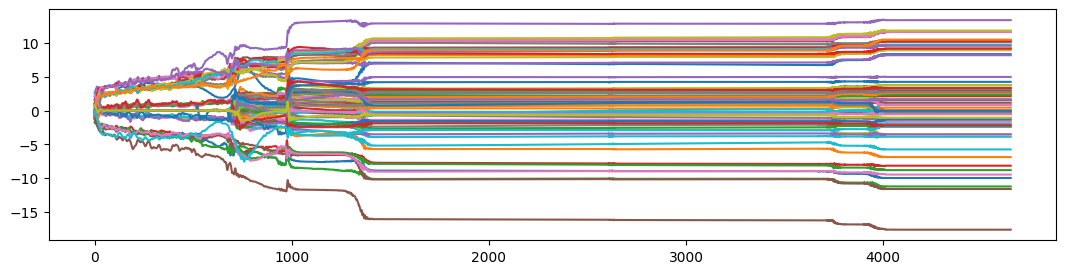

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,3))
plt.plot(coeff.cpu().numpy())
plt.show()

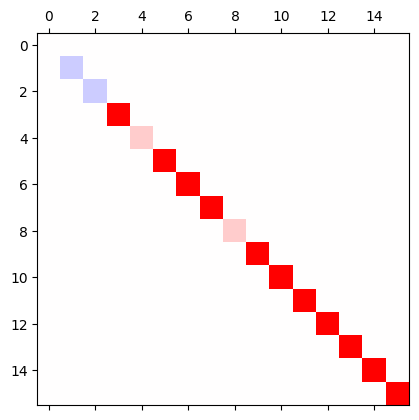

In [ ]:
import matplotlib.pyplot as plt
plt.matshow(model.interaction[0].singleOrbs[0].Hint.to_dense().cpu(), cmap="bwr", vmin=-1, vmax=1)

In [ ]:
torch.linalg.eigh(model.interaction[0].singleOrbs[0].Hint.to_dense())

In [ ]:
SBamp = model.interaction[0].singleOrbs[0].SBamp

vnorm = SBamp.norm()
sb = torch.cat([2*SBamp, vnorm.unsqueeze(0)**2-1]) / (vnorm**2+1)
sb = torch.sparse_coo_tensor(model.interaction[0].singleOrbs[0].indices, sb, model.interaction[0].singleOrbs[0].size).coalesce()

In [ ]:
data["variational_density"]

tensor([[ 4.4115e-01,  1.9829e-02,  3.1650e-06,  5.0934e-06],
        [ 1.9829e-02,  3.4467e-01, -1.5131e-06, -2.2920e-06],
        [ 3.1650e-06, -1.5131e-06,  5.8422e-01,  4.1107e-02],
        [ 5.0934e-06, -2.2920e-06,  4.1107e-02,  6.1719e-01]], device='cuda:0',
       grad_fn=<BlockDiagBackward0>)

In [ ]:
import matplotlib.pyplot as plt
plt.matshow(sb.to_dense().detach().cpu())
plt.plot()
plt.matshow((sb.to_dense() @ sb.to_dense().T).detach().cpu())
plt.plot()
plt.matshow((sb.to_dense().T @ sb.to_dense()).detach().cpu())
plt.plot()

In [ ]:
from gGA.model.operators import annis
plt.matshow((annis[(2, 1, 0)].to_dense().T @ annis[(2, 1, 0)].to_dense()).cpu())
plt.show()


In [ ]:
import matplotlib.pyplot as plt
phi = torch.stack(phi)

In [ ]:
plt.plot((phi / phi.norm(dim=0, keepdim=True)).detach().cpu().numpy())
plt.show()

In [ ]:
model.lagrangian[0], data["variational_density"], data["reduced_density_matrix"]

(Parameter containing:
 tensor([[407.3792,  75.0879,  13.9896,  28.2752],
         [ 75.0879, 432.1221,  16.3083,  10.0340],
         [ 13.9896,  16.3083, 409.0904,   8.3813],
         [ 28.2752,  10.0340,   8.3813, 490.7886]], device='cuda:0',
        requires_grad=True),
 tensor([[ 4.8889e-01, -3.7389e-02, -1.0439e-04, -1.0913e-05],
         [-3.7389e-02,  5.9534e-01,  7.2451e-05,  9.4126e-05],
         [-1.0439e-04,  7.2451e-05,  4.5388e-01,  3.0272e-05],
         [-1.0913e-05,  9.4126e-05,  3.0272e-05,  4.5433e-01]], device='cuda:0',
        grad_fn=<BlockDiagBackward0>),
 tensor([[ 4.9078e-01, -3.7217e-02, -1.9538e-04, -5.1720e-05],
         [-3.7217e-02,  5.9713e-01,  4.2640e-05,  1.4229e-04],
         [-1.9538e-04,  4.2640e-05,  4.5601e-01,  9.2659e-06],
         [-5.1720e-05,  1.4229e-04,  9.2659e-06,  4.5608e-01]], device='cuda:0',
        grad_fn=<DivBackward0>))

In [7]:
model.interaction[0].compute_density().reshape(4,4)

tensor([[ 1.9896e-05,  3.8183e-06, -4.6264e-04, -6.5582e-04],
        [ 3.8183e-06,  1.4201e-05,  2.8465e-04, -5.9485e-05],
        [-4.6264e-04,  2.8465e-04,  9.9787e-01,  1.9863e-03],
        [-6.5582e-04, -5.9485e-05,  1.9863e-03,  9.8273e-01]], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [8]:
data["r_matrix"][0].T @ data["r_matrix"][0]

tensor([[ 8.0702e-06,  5.8125e-06,  3.1665e-05,  2.1975e-04],
        [ 5.8125e-06,  5.8966e-06,  6.4499e-05,  1.0872e-04],
        [ 3.1665e-05,  6.4499e-05,  4.2806e-03, -3.8043e-03],
        [ 2.1975e-04,  1.0872e-04, -3.8043e-03,  3.2778e-02]], device='cuda:0',
       grad_fn=<MmBackward0>)

In [ ]:
model.interaction[0].singleOrbs[0].check_B()

tensor([[ 2.2067e-04,  2.0431e-04,  2.2855e-01, -3.2726e-01],
        [ 2.7686e-04, -6.6057e-04, -3.3012e-01, -2.2699e-01],
        [ 3.0082e-01, -2.7219e-01, -4.6011e-04, -4.3698e-04],
        [-2.7080e-01, -2.9726e-01, -3.7155e-04,  1.4327e-04]], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [ ]:
data[_keys.VARIATIONAL_DENSITY_KEY], data[_keys.REDUCED_DENSITY_MATRIX_KEY]

(tensor([[ 4.8377e-01,  2.6986e-02,  7.8418e-04, -3.8548e-04],
         [ 2.6986e-02,  4.9081e-01,  1.5266e-03,  1.3008e-03],
         [ 7.8418e-04,  1.5266e-03,  4.7107e-01, -1.3093e-02],
         [-3.8548e-04,  1.3008e-03, -1.3093e-02,  5.5301e-01]], device='cuda:0',
        grad_fn=<BlockDiagBackward0>),
 tensor([[ 4.8428e-01,  2.6985e-02,  7.8491e-04, -3.8367e-04],
         [ 2.6985e-02,  4.9106e-01,  1.5265e-03,  1.2988e-03],
         [ 7.8491e-04,  1.5265e-03,  4.7126e-01, -1.3091e-02],
         [-3.8367e-04,  1.2988e-03, -1.3091e-02,  5.5340e-01]], device='cuda:0',
        grad_fn=<DivBackward0>))

In [ ]:
import matplotlib.pyplot as plt
# phi = torch.stack(phi)
phi = phi /  phi.norm(dim=-1, keepdim=True)
plt.figure(figsize=(10,3))
plt.plot(phi[:,:].cpu().detach().numpy())
# plt.plot(grad[1].cpu().abs().reshape(448,-1).max(dim=1)[0])
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.matshow(model.interaction[0].singleOrbs[0].check_sbbs().to_dense().detach().cpu(), cmap="bwr", vmax=0.1, vmin=-0.1)
plt.show()

plt.matshow(model.interaction[0].singleOrbs[0].Hint.to_dense().detach().cpu(), cmap="bwr", vmax=0.1, vmin=-0.1)
plt.show()

In [ ]:
model.interaction[0].singleOrbs[0].compute_density().reshape(4,4)

tensor([[ 0.5104, -0.0449,  0.0048, -0.0040],
        [-0.0449,  0.4903, -0.0014,  0.0033],
        [ 0.0048, -0.0014,  0.4962,  0.0237],
        [-0.0040,  0.0033,  0.0237,  0.5020]], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [ ]:
mask = (model.interaction[0].singleOrbs[0].SBamp / model.interaction[0].singleOrbs[0].SBamp.norm()).abs().gt(0.08)

In [ ]:
(model.interaction[0].singleOrbs[0].SBamp / model.interaction[0].singleOrbs[0].SBamp.norm())[mask]

In [ ]:
torch.tensor(model.interaction[0].singleOrbs[0].basis)[mask.cpu()]

In [ ]:
vec = torch.zeros(16)
vec[5] = 1
vec.T @ model.interaction[0].singleOrbs[0].Hint.to_dense().cpu() @ vec

In [ ]:
mask = (model.interaction[0].singleOrbs[0].SBamp.abs() / model.interaction[0].singleOrbs[0].SBamp.norm()).gt(0.05)

In [ ]:
torch.cat([model.interaction[0].singleOrbs[0].basis, model.interaction[0].singleOrbs[0].SBamp.unsqueeze(1)], dim=-1)[mask]

In [ ]:
import torch

M = torch.randn(10,10)
M = M + M.T
M[:5,:5] = 0

In [ ]:
A = M[:3,3:].clone()
B = M[3:,3:].clone()
Binv = B.inverse()
ABinv = torch.linalg.solve(B.T, A.T).T
inv00 = -(ABinv @ A.T).inverse()
inv01 = -inv00 @ ABinv
inv11 = Binv - ABinv.T @ inv01



In [ ]:
import matplotlib.pyplot as plt
plt.matshow(M.inverse() - Minv, cmap="bwr", vmax=0.1, vmin=-0.1)
plt.show()